In [1]:
%%capture
%pip install -U neptune
%pip install evaluate
%pip install jiwer

In [2]:
import evaluate

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import xml.etree.ElementTree as ET
import re
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import time
from datetime import datetime
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms as T
import torchvision
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
import torch

device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
config={
    'encoder_model_name':'google/vit-base-patch16-224-in21k', # as encoder
    'decoder_model_name':'dis|tilgpt2',     # DistilGPT-2 as the decoder
    'feature_extractor_name':'microsoft/resnet-50',
    'tokenizer_name':'tirthadagr8/CustomOCR',
    
}


In [3]:
images=[]
annotations = []
labels=[]
raw_path='/kaggle/input/manga109-synthetic/data/manga/Manga109/'
synth_path='/kaggle/input/manga109-synthetic/data/manga/synthetic/'
raw_manga=pd.read_csv(raw_path+'data.csv')
synthetic_manga=pd.read_csv(synth_path+'meta/0000.csv')
drop_rows=[]
for i,text in enumerate(raw_manga['text']):
    if len(text)>=63:
        drop_rows.append(i)
raw_manga.drop(drop_rows,inplace=True)
print(f'Removed {len(drop_rows)} rows from raw_manga')
drop_rows=[]
for i,text in enumerate(synthetic_manga['text']):
    if len(text)>=63:
        drop_rows.append(i)
synthetic_manga.drop(drop_rows,inplace=True)
print(f'Removed {len(drop_rows)} rows from synthetic_manga')
raw_manga['path']=raw_path+raw_manga['crop_path']
synthetic_manga['path']=synth_path+'img/0000/'+synthetic_manga['id']+'.jpg'
images=list(raw_manga['path'].values)+list(synthetic_manga['path'].values)
labels=list(raw_manga['text'].values)+list(synthetic_manga['text'].values)

Removed 502 rows from raw_manga
Removed 3166 rows from synthetic_manga


In [10]:
all_chars=['░']+sorted(list(set(''.join(labels))))
char_to_int={j:i for i,j in enumerate(all_chars)}
int_to_char={i:j for i,j in enumerate(all_chars)}

def text_operation(s=None,arr=None,padding=False,return_tensor=True,max_length=64,remove_padding=False):
    if s is not None:
        ans=[]
        for i in s:
            ans.append(char_to_int[i])
        if padding:
            ans+=[0]*(max_length-len(ans))
        if return_tensor:
            return torch.tensor(ans,dtype=torch.long)
    if arr is not None:
        ans=''
        if isinstance(arr,torch.Tensor):
            arr=arr.clone().detach().cpu().numpy()
        for i in arr:
            if not (remove_padding and i==0):
                ans+=int_to_char[i]
        return ans

In [11]:
class DatasetLoaderPrivate2(Dataset):
    def __init__(self,images,labels) -> None:
        super().__init__()
        self.transforms = T.Compose([
            T.Resize((224,224)),
            T.RandomPerspective(distortion_scale=0.2, p=0.5),
            T.RandomRotation(5),
            T.GaussianBlur(3),
            T.RandomAdjustSharpness(2),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.simple_transforms=T.Compose([
            T.Resize((224,224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer=AutoTokenizer.from_pretrained('tirthadagr8/CustomOCR')
        self.images=images
        self.labels=labels
        # for i in range(len(self.labels)):
        #     self.labels[i]=convert_fullwidth_to_halfwidth(self.labels[i])
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        augment=False
        if index>=len(self.images):
            index%=len(self.images)
            augment=True
        if augment:
            img=self.transforms(Image.open(self.images[index]).convert('RGB'))
        else:
            img=self.simple_transforms(Image.open(self.images[index]).convert('RGB'))
        text=torch.tensor(self.tokenizer.encode(f'{self.tokenizer.bos_token}{self.labels[index]}{self.tokenizer.eos_token}',padding='max_length',max_length=64),dtype=torch.long)
        attn_mask=torch.tensor([1]*(2+len(self.labels[index]))+[0]*(62-len(self.labels[index])),dtype=torch.long)
        return {
            'pixel_values':img,
            'input_ids':text,
            'labels':text,
            'attention_mask':attn_mask
        }

  0%|          | 0/584458 [00:00<?, ?it/s]

統サ啓谷格漏朋
昇禍綴妓諌
暦し割


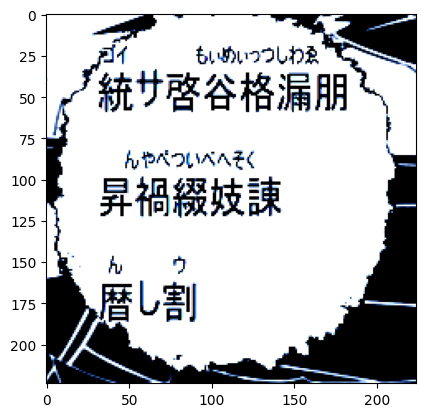

  0%|          | 0/584458 [00:00<?, ?it/s]


In [14]:
if __name__=='__main__':
    dd=DatasetLoaderPrivate2(images,labels)
    d=DataLoader(dd,batch_size=1,shuffle=True)
    tokenizer=AutoTokenizer.from_pretrained('tirthadagr8/CustomOCR')
    import matplotlib.pyplot as plt
    c=0
    ttt=[]
    for t in tqdm(d):
#         for l in t[1][0]:
#             ttt.append(torch.argmax(l).item())
        print(tokenizer.decode(t['labels'][0],skip_special_tokens=True))
#         print(dd.tokenizer.decode(t[1][0],skip_special_token=True))
        # if c>8:
        #     break
        c+=1
        plt.imshow(t['pixel_values'][0].detach().cpu().permute(1,2,0))
        plt.show()
        break

In [15]:
# Step 2: Create VisionEncoderDecoderModel
tokenizer=AutoTokenizer.from_pretrained(config['tokenizer_name'])
from transformers import ViTConfig, GPT2Config, VisionEncoderDecoderConfig

# Custom encoder config
encoder_config = ViTConfig(
    image_size=224,
    patch_size=16,
    num_channels=3,
    hidden_size=768,  # Original: 384 (vit-small)
    num_hidden_layers=12,  # Reduced from 12
    num_attention_heads=12,  # Original: 6
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    initializer_range=0.02,
    layer_norm_eps=1e-6,
    is_training=True,
    patch_attention= True  # Custom: Enable patch-wise attention
)

# Custom decoder config
decoder_config = GPT2Config(
    vocab_size=len(tokenizer.vocab),  # Original: 50257
    n_positions=512,  # Reduced from 1024 for OCR
    n_embd=768,
    n_layer=12,  # Original: 12
    n_head=12,  # Original: 12
    n_inner=2048,
    activation_function="gelu_new",
    resid_pdrop=0.1,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    layer_norm_epsilon=1e-5,
    initializer_range=0.02,
    scale_attn_weights=True,
    use_cache=False,  # Disable for training
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    add_cross_attention=True  # Essential for encoder-decoder
)
main_config=VisionEncoderDecoderConfig.from_encoder_decoder_configs(encoder_config, decoder_config)
# model=VisionEncoderDecoderModel(main_config)
from transformers import VisionEncoderDecoderModel

model=VisionEncoderDecoderModel.from_pretrained('tirthadagr8/CustomOCR')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model)/1e6:.1f}M")
# Step 3: Set Special Tokens and Configuration
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id

# Optional: Adjust max length for generation
model.config.max_length = 64  # Maximum output sequence length

model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams=5

config.json:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/764M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.1,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_training": true,
  "layer_norm_eps": 1e-06,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_attention": true,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "attn_pdrop": 0.1,
  "bos_token_id": 12561,
  "embd_pdrop": 0.1,
  "eos_token_id": 12562,
  "initializer_range": 0.02,
  "is_decoder": true,
  "layer_norm_epsilon": 1e-05,
  "model_ty

generation_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

Trainable parameters: 191.0M


In [16]:
import neptune
from kaggle_secrets import UserSecretsClient

neptune_api = UserSecretsClient().get_secret("NEPTUNE_API_TOKEN")
neptune_project =UserSecretsClient().get_secret("NEPTUNE_PROJECT")

from transformers.integrations import NeptuneCallback
neptune_callback = NeptuneCallback(
    project=neptune_project,
    api_token=neptune_api
)

In [17]:
import numpy as np

class Metrics:
    def __init__(self, tokenizer):
        self.cer_metric = evaluate.load("cer")
        self.processor = tokenizer

    def compute_metrics(self, pred):
        label_ids = pred.label_ids
        pred_ids = pred.predictions
        print(label_ids.shape, pred_ids.shape)

        pred_str = self.processor.batch_decode(pred_ids, skip_special_tokens=True)
        label_ids[label_ids == -100] = self.processor.pad_token_id
        label_str = self.processor.batch_decode(label_ids, skip_special_tokens=True)

        pred_str = np.array(["".join(text.split()) for text in pred_str])
        label_str = np.array(["".join(text.split()) for text in label_str])

        results = {}
        try:
            results["cer"] = self.cer_metric.compute(predictions=pred_str, references=label_str)
        except Exception as e:
            print(e)
            print(pred_str)
            print(label_str)
            results["cer"] = 0
        results["accuracy"] = (pred_str == label_str).mean()

        return results
metrics=Metrics(tokenizer)

In [20]:
batch_size=32
train_dataset = DatasetLoaderPrivate2(images[:-1000], labels[:-1000])
val_dataset = DatasetLoaderPrivate2(images[-1000:], labels[-1000:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


# Step 5: Define Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./ocr-model",
    learning_rate=5e-5,
    predict_with_generate=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    lr_scheduler_type='cosine',
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=2,
    max_steps=30000,
    save_steps=1000,
    eval_steps=1000,
    save_total_limit=1,
    report_to='none',
    fp16=True,  # Enable mixed precision training if GPU supports it
)

# Step 6: Define Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics.compute_metrics,
    data_collator=None,  # Default collator works for VisionEncoderDecoderModel
    callbacks=[neptune_callback]
)

# Step 7: Train the Model
trainer.train()

# Step 8: Save the Model
model.save_pretrained("./ocr-model")
tokenizer.save_pretrained("./ocr-model")

Step,Training Loss
2,1.606800
4,1.738300
6,1.230800
8,1.348000
10,1.269700
12,1.593000
14,1.377500
16,1.211600
18,1.365800
20,1.532100


KeyboardInterrupt: 

In [26]:
print(tokenizer.batch_decode(model.cuda().generate(t['pixel_values'][0].unsqueeze(0).cuda()),skip_special_tokens=True)[0])

納金
柏松納
柏金
潔
宿題
明
題
画


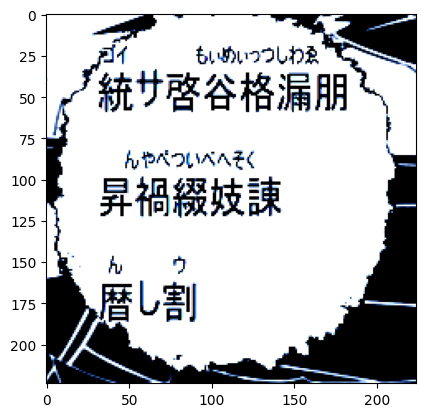

In [22]:
plt.imshow(t['pixel_values'][0].detach().cpu().permute(1,2,0))